## Zadanie domowe: BBHE i DSIHE

W klasycznym wyrównywaniu histogramu HE  po wykonaniu operacji jasność obrazu ulega zmianie.
Dało się to zaobserwować podczas przeprowadzonych eksperymentów.
Jeśli nie to należy uruchomić skrypt z sekcji A i zwrócić na to uwagę.
Średnia jasność dąży do środkowego poziomu szarości.
Jest to wada i dlatego klasyczne HE ma ograniczone zastosowanie.

Powstało sporo metod, które eliminują to niekorzystne zjawisko.
Najprostsze z nich polegają na dekompozycji obrazu wejściowego na dwa podobrazy (wg. pewnego kryterium).
Następnie operacja HE wykonywana jest dla tych podobrazów.

Dwie znane z literatury metody to:
- Bi-Histogram Equalization
- DSIHE - Dualistic Sub-Image Histogram Equalization

W metodzie BBHE za kryterium podziału przyjmuje się średnią jasność w obrazie.
W DSIHE obraz dzieli się na dwa podobrazy o takiej samej liczbie pikseli (jaśniejszych i ciemniejszych).

W ramach zadania należy zaimplementować wybraną metodę: BBHE lub DSIHE (ew. obie).

1. Wczytaj obraz *jet.bmp* i wylicz jego histogram.
2. W kolejnym kroku należy wyznaczyć próg podziału obrazu na dwa podobrazy (*lm*).
3. Dla BBHE wyznacz średnią jasność obrazu. Dla DSIHE można wykorzystać histogram skumulowany.
Należy znaleźć poziom jasności który znajduje się "w połowie" histogramu skumulowanego.
W tym celu warto stworzyć tablicę, zawierającą moduł histogramu skumulowanego pomniejszonego o połowę liczby pikseli.
Następnie znaleźć minimum - `np.argmin`.
4. Dalej należy podzielić histogram oryginalnego obrazu na dwa histogramy *H1* i *H2*.
Dla każdego z nich wyliczyć histogram skumulowany ($C_1$ i $C_2$) i wykonać normalizację.
Normalizacja polega na podzieleniu każdego histogramu przez jego największy element.
5. Na podstawie histogramów skumulowanych należy stworzyć przekształcenie LUT.
Należy tak przeskalować $C_1$ i $C_2$, aby uzyskać jednorodne przekształcenie.
Tablicę $C_1$ wystarczy pomnożyć przez próg podziału.
Tablicę $C_2$ należy przeskalować do przedziału: $<lm+1; 255>$, gdzie $lm$ jest progiem podziału.<br>
$C_{1n} = (lm)*C1;$<br>
$C_{2n} = lm+1 + (255-lm-1)*C2;$<br>
Następnie dwie części tablicy przekodowań należy połączyć.
6. Ostatecznie należy wykonać operację LUT i wyświetlić wynik wyrównywania histogramu.
Porównaj wynik operacji BBHE lub DSIHE z klasycznym HE.

In [1]:
import cv2
import os
import requests
from matplotlib import pyplot as plt
import numpy as np

url = 'https://raw.githubusercontent.com/vision-agh/poc_sw/master/03_Histogram/'
fileName = 'jet.bmp'
if not os.path.exists(fileName) :
    r = requests.get(url + fileName, allow_redirects=True)
    open(fileName, 'wb').write(r.content)

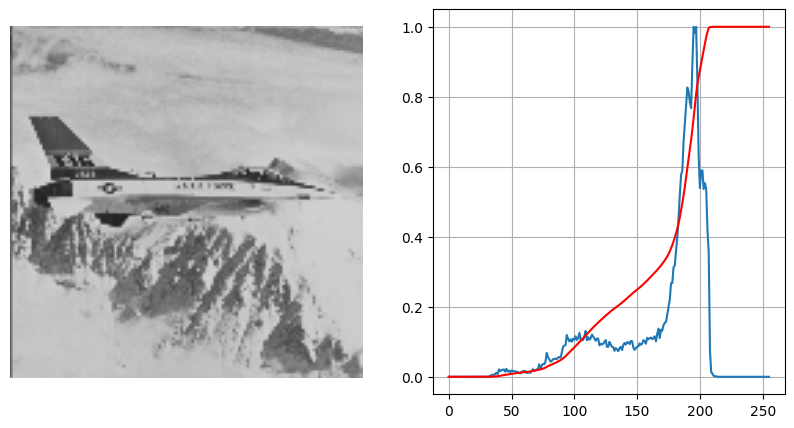

In [2]:
jet_img = cv2.imread('jet.bmp', cv2.IMREAD_GRAYSCALE)

fig, axs = plt.subplots(1, 2)
fig.set_size_inches(10, 5)

axs[0].imshow(jet_img, 'gray', vmin=0, vmax=256)
axs[0].axis('off')

hist = cv2.calcHist([jet_img], [0], None, [256], [0, 256])
cumulative_hist = np.cumsum(hist)

axs[1].plot(hist / np.max(hist))
axs[1].plot(cumulative_hist / np.max(cumulative_hist), c='red') 
axs[1].grid()

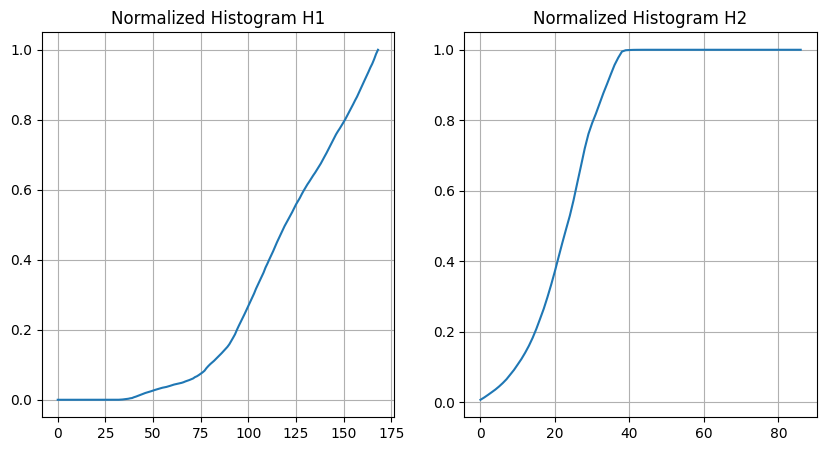

In [3]:
mean_brightness = np.mean(jet_img)
lm = int(mean_brightness)

H1 = hist[:lm]
H2 = hist[lm:]

cumulative_H1 = np.cumsum(H1)
cumulative_H2 = np.cumsum(H2)

H1_normalized = cumulative_H1 / np.max(cumulative_H1)
H2_normalized = cumulative_H2 / np.max(cumulative_H2)

fig, axs = plt.subplots(1, 2)
fig.set_size_inches(10, 5)

axs[0].plot(H1_normalized)
axs[0].set_title("Normalized Histogram H1")
axs[0].grid()

axs[1].plot(H2_normalized)
axs[1].set_title("Normalized Histogram H2")  
axs[1].grid()

In [4]:
LUT = np.zeros(256, dtype=np.uint8)

for i in range(lm):
    LUT[i] = np.uint8(lm * H1_normalized[i])

for i in range(lm, 256):
    LUT[i] = np.uint8(lm + 1 + (255 - lm - 1) * H2_normalized[i - lm])
    

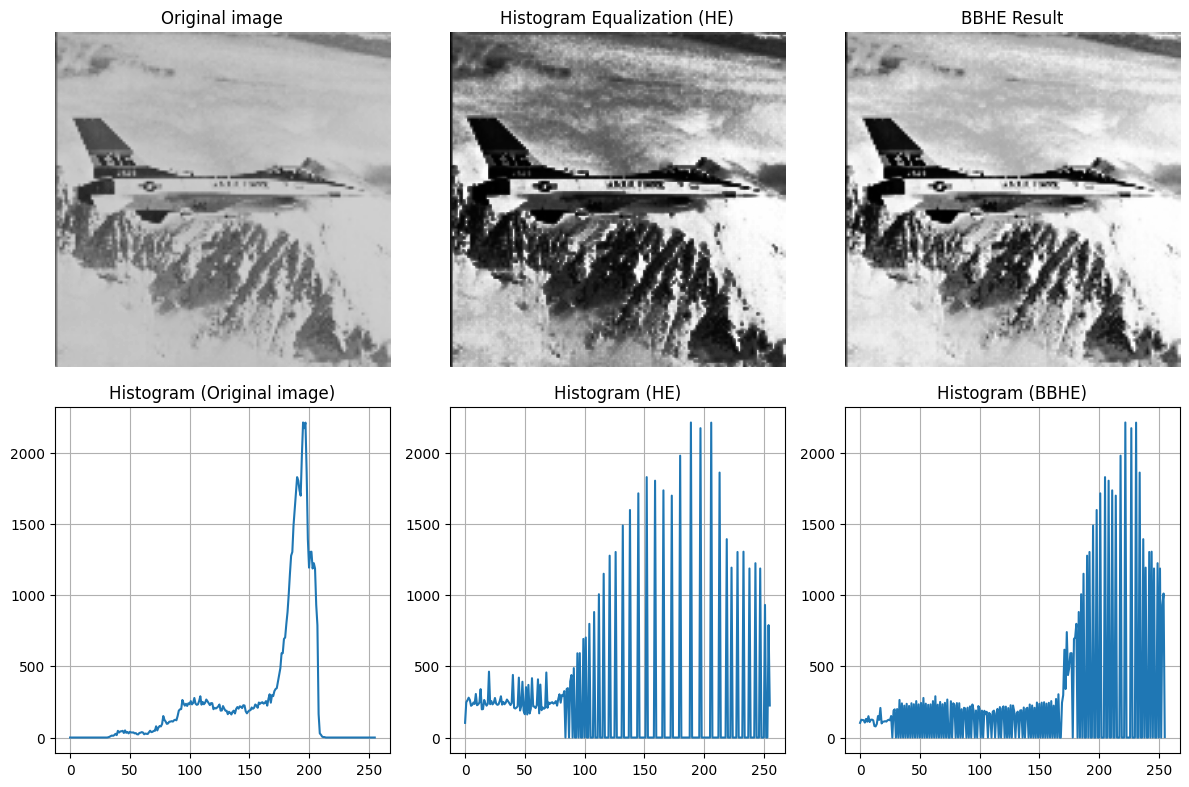

In [5]:
result_image = cv2.LUT(jet_img, LUT)
he_image = cv2.equalizeHist(jet_img)

hist_jet_img = cv2.calcHist([jet_img], [0], None, [256], [0, 256])
hist_he_image = cv2.calcHist([he_image], [0], None, [256], [0, 256])
hist_result_image = cv2.calcHist([result_image], [0], None, [256], [0, 256])

fig, axs = plt.subplots(2, 3)
fig.set_size_inches(12, 8)

axs[0, 0].imshow(jet_img, 'gray', vmin=0, vmax=256)
axs[0, 0].axis('off')
axs[0, 0].set_title("Original image")

axs[1, 0].plot(hist_jet_img)
axs[1, 0].set_title("Histogram (Original image)")
axs[1, 0].grid()

axs[0, 1].imshow(he_image, 'gray', vmin=0, vmax=256)
axs[0, 1].axis('off')
axs[0, 1].set_title("Histogram Equalization (HE)")

axs[1, 1].plot(hist_he_image)
axs[1, 1].set_title("Histogram (HE)")
axs[1, 1].grid()

axs[0, 2].imshow(result_image, 'gray', vmin=0, vmax=256)
axs[0, 2].axis('off')
axs[0, 2].set_title("BBHE Result")

axs[1, 2].plot(hist_result_image)
axs[1, 2].set_title("Histogram (BBHE)")
axs[1, 2].grid()

plt.tight_layout()
plt.show()